# Library / Packages

In [1]:
# basic
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde

# data preparation
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer 

# data modeling
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

# data scoring
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# data tuning   
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split

# visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# Format

In [2]:
def lab_round(x, pos): 
    if abs(x) >= 1e9: 
        return f'{x/1e9} B'
    
    elif abs(x) >= 1e6:
        return f'{x/1e6} M'
    
    elif abs(x) >= 1e3:
        return f'{x/1e3} K'
    
    else:
        return f'{x}'
    
def val_round(x):
    if abs(x) >= 1e9:
        return f'{x/1e9:.2f} B'
    
    elif abs(x) >= 1e6:
        return f'{x/1e6:.2f} M'
    
    elif abs(x) >= 1e3:
        return f'{x/1e3:.2f} K'
    
    else:
        return f'{x:.2f}'

In [3]:
def filter_outliers_iqr(df, columns = None, threshold = 1.5):
    # Jika tidak ada kolom yang ditentukan, gunakan semua kolom numerik
    if columns is None:
        columns = df.select_dtypes(include = ["number"]).columns.tolist()
    
    # Salin DataFrame untuk memastikan tidak ada modifikasi langsung
    df_filtered = df.copy()
    
    for column in columns:
        # Hitung Q1, Q3, dan IQR
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        # Hitung batas bawah dan atas
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        
        # Hapus baris dengan outlier
        df_filtered = df_filtered[(df_filtered[column] >= lower_bound) & (df_filtered[column] <= upper_bound)]
    
    return df_filtered

In [4]:
# Fungsi untuk konversi tipe data
def convert_object_columns_to_numeric(df):
    for col in df.select_dtypes(include = ['object']).columns:  
        try:
            # Cek apakah semua nilai bisa dikonversi ke float
            df[col] = pd.to_numeric(df[col], errors='raise')
            
            # Jika bisa, ubah ke int jika semua nilai adalah bilangan bulat
            if all(df[col] % 1 == 0):  # Cek apakah semua nilai adalah bilangan bulat
                df[col] = df[col].astype(int)

        except ValueError:
            pass  # Jika ada nilai non-angka, biarkan tetap object
        
    return df

# Dataset

In [5]:
# Memuat data train dan test
train_df = pd.read_csv('../dataset/train.csv')
test_df = pd.read_csv('../dataset/test.csv')

In [6]:
# show all column
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Train Dataset

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [8]:
# drop column
train_df = train_df.drop('Id', axis = 1)

# convert object if all numeric
train_df = convert_object_columns_to_numeric(train_df)

# check duplicate general data
print(f'Total General Duplicated: {train_df.duplicated().sum()} \n')
train_df.info()

Total General Duplicated: 0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 no

In [9]:
# Menambahkan underscore di antara huruf kapital
train_df.columns = train_df.columns.str.replace(r'([a-z])([A-Z])', r'\1_\2', regex = True)

# change into lowercase
train_df.columns = train_df.columns.str.lower()

# Memeriksa nama kolom setelah perubahan
list(train_df.columns)

['mssub_class',
 'mszoning',
 'lot_frontage',
 'lot_area',
 'street',
 'alley',
 'lot_shape',
 'land_contour',
 'utilities',
 'lot_config',
 'land_slope',
 'neighborhood',
 'condition1',
 'condition2',
 'bldg_type',
 'house_style',
 'overall_qual',
 'overall_cond',
 'year_built',
 'year_remod_add',
 'roof_style',
 'roof_matl',
 'exterior1st',
 'exterior2nd',
 'mas_vnr_type',
 'mas_vnr_area',
 'exter_qual',
 'exter_cond',
 'foundation',
 'bsmt_qual',
 'bsmt_cond',
 'bsmt_exposure',
 'bsmt_fin_type1',
 'bsmt_fin_sf1',
 'bsmt_fin_type2',
 'bsmt_fin_sf2',
 'bsmt_unf_sf',
 'total_bsmt_sf',
 'heating',
 'heating_qc',
 'central_air',
 'electrical',
 '1st_flr_sf',
 '2nd_flr_sf',
 'low_qual_fin_sf',
 'gr_liv_area',
 'bsmt_full_bath',
 'bsmt_half_bath',
 'full_bath',
 'half_bath',
 'bedroom_abv_gr',
 'kitchen_abv_gr',
 'kitchen_qual',
 'tot_rms_abv_grd',
 'functional',
 'fireplaces',
 'fireplace_qu',
 'garage_type',
 'garage_yr_blt',
 'garage_finish',
 'garage_cars',
 'garage_area',
 'garage_qua

In [10]:
train_df.head()

,mssub_class,mszoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition1,condition2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod_add,roof_style,roof_matl,exterior1st,exterior2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmt_fin_type1,bsmt_fin_sf1,bsmt_fin_type2,bsmt_fin_sf2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abv_gr,kitchen_abv_gr,kitchen_qual,tot_rms_abv_grd,functional,fireplaces,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,sale_condition,sale_price
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [11]:
# null column
null_numeric = []
null_obj = []

# 
null_columns = train_df.columns[train_df.isnull().sum() > 0]

for col in null_columns:
    if train_df[col].dtype in ['int', 'float']:
        null_numeric.append(col)
        
    elif train_df[col].dtype == 'object':
        null_obj.append(col)

# 
print("Null Numeric:", null_numeric)
print("Null String:", null_obj)

Null Numeric: ['lot_frontage', 'mas_vnr_area', 'garage_yr_blt']
Null String: ['alley', 'mas_vnr_type', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure', 'bsmt_fin_type1', 'bsmt_fin_type2', 'electrical', 'fireplace_qu', 'garage_type', 'garage_finish', 'garage_qual', 'garage_cond', 'pool_qc', 'fence', 'misc_feature']


In [12]:
# 
num_cols = []
obj_cols = []

for col in train_df:
    if train_df[col].dtype in ['int', 'float']:
        num_cols.append(col)
        
    elif train_df[col].dtype == 'object':
        obj_cols.append(col)

# 
print("Numeric Cols:", num_cols)
print("String Cols:", obj_cols)

Numeric Cols: ['lot_frontage', 'mas_vnr_area', 'garage_yr_blt']
String Cols: ['mszoning', 'street', 'alley', 'lot_shape', 'land_contour', 'utilities', 'lot_config', 'land_slope', 'neighborhood', 'condition1', 'condition2', 'bldg_type', 'house_style', 'roof_style', 'roof_matl', 'exterior1st', 'exterior2nd', 'mas_vnr_type', 'exter_qual', 'exter_cond', 'foundation', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure', 'bsmt_fin_type1', 'bsmt_fin_type2', 'heating', 'heating_qc', 'central_air', 'electrical', 'kitchen_qual', 'functional', 'fireplace_qu', 'garage_type', 'garage_finish', 'garage_qual', 'garage_cond', 'paved_drive', 'pool_qc', 'fence', 'misc_feature', 'sale_type', 'sale_condition']


In [13]:
# Original columns
train_original = train_df.columns

# Numeric Pipeline
numerical_pipeline = Pipeline(steps = [
    ("imputer", SimpleImputer(strategy = "mean"))
])

# String Pipeline
categorical_pipeline = Pipeline(steps = [
    ("imputer", SimpleImputer(strategy = "most_frequent"))
])

# ColumnTransformer untuk menggabungkan proses imputasi
prep_stage_1 = ColumnTransformer(
    transformers = [
        ("num", numerical_pipeline, num_cols), 
        ("cat", categorical_pipeline, obj_cols), 
    ], 
    remainder = 'passthrough', 
    verbose_feature_names_out = True)

In [14]:
# Transform data menggunakan fit_transform pada tahap 1
train_df = prep_stage_1.fit_transform(train_df)

# Columns After: ubah kembali ke DataFrame dengan kolom dari prep_stage_1
train_df = pd.DataFrame(train_df, columns = prep_stage_1.get_feature_names_out())

# Hilangkan prefix (misalnya, "num__", "cat__", "out__")
clean_columns = [col.split("__", 1)[-1] for col in train_df.columns]
train_df.columns = clean_columns

In [15]:
# Menampilkan total null pada setiap kolom
null_columns = train_df.isnull().sum()[train_df.isnull().sum() > 0]
print(f'Total null columns: {null_columns} \n')
train_df.info()

Total null columns: Series([], dtype: int64) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   lot_frontage     1460 non-null   object
 1   mas_vnr_area     1460 non-null   object
 2   garage_yr_blt    1460 non-null   object
 3   mszoning         1460 non-null   object
 4   street           1460 non-null   object
 5   alley            1460 non-null   object
 6   lot_shape        1460 non-null   object
 7   land_contour     1460 non-null   object
 8   utilities        1460 non-null   object
 9   lot_config       1460 non-null   object
 10  land_slope       1460 non-null   object
 11  neighborhood     1460 non-null   object
 12  condition1       1460 non-null   object
 13  condition2       1460 non-null   object
 14  bldg_type        1460 non-null   object
 15  house_style      1460 non-null   object
 16  roof_style       1460 non-null 

In [16]:
# change object after transform
train_df = convert_object_columns_to_numeric(train_df)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   lot_frontage     1460 non-null   float64
 1   mas_vnr_area     1460 non-null   float64
 2   garage_yr_blt    1460 non-null   float64
 3   mszoning         1460 non-null   object 
 4   street           1460 non-null   object 
 5   alley            1460 non-null   object 
 6   lot_shape        1460 non-null   object 
 7   land_contour     1460 non-null   object 
 8   utilities        1460 non-null   object 
 9   lot_config       1460 non-null   object 
 10  land_slope       1460 non-null   object 
 11  neighborhood     1460 non-null   object 
 12  condition1       1460 non-null   object 
 13  condition2       1460 non-null   object 
 14  bldg_type        1460 non-null   object 
 15  house_style      1460 non-null   object 
 16  roof_style       1460 non-null   object 
 17  roof_matl     

In [17]:
# Cetak jumlah baris sebelum filter
print(f"Total Rows Before Filtering: {len(train_df)}")

# Pilih kolom numerik
num_cols = train_df.select_dtypes(include = ["number"]).columns

# Terapkan filter pada kolom numerik
train_df = filter_outliers_iqr(train_df, columns = num_cols)

# Cetak jumlah baris setelah filter
print(f"Total Rows After Filtering: {len(train_df)}")

Total Rows Before Filtering: 1460
Total Rows After Filtering: 557


In [18]:
# Daftar kolom untuk label encoding (kolom ordinal)
encoding_set = {'overall_qual', 'overall_cond', 'exter_qual', 'exter_cond', 
                'bsmt_qual', 'Bsmt_cond', 'heating_qc', 'kitchen_qual', 
                'fireplace_qu', 'garage_qual', 'garage_cond'}

# Inisialisasi list untuk menyimpan kolom yang telah dikelompokkan
train_ordinal_cols = []
train_one_hot_cols = []
train_numeric_cols = []

# Mengelompokkan kolom berdasarkan tipe data
for col in train_df.columns:
    if train_df[col].dtype in ['int', 'float']:
        train_numeric_cols.append(col)

    elif train_df[col].dtype == 'object':
        if col in encoding_set:
            train_ordinal_cols.append(col)

        else:
            train_one_hot_cols.append(col)

# Menampilkan hasil
print("Ordinal Encoding Columns:", train_ordinal_cols)
print("One-Hot Encoding Columns:", train_one_hot_cols)
print("Numeric Columns:", train_numeric_cols)

Ordinal Encoding Columns: ['exter_qual', 'exter_cond', 'bsmt_qual', 'heating_qc', 'kitchen_qual', 'fireplace_qu', 'garage_qual', 'garage_cond']
One-Hot Encoding Columns: ['mszoning', 'street', 'alley', 'lot_shape', 'land_contour', 'utilities', 'lot_config', 'land_slope', 'neighborhood', 'condition1', 'condition2', 'bldg_type', 'house_style', 'roof_style', 'roof_matl', 'exterior1st', 'exterior2nd', 'mas_vnr_type', 'foundation', 'bsmt_cond', 'bsmt_exposure', 'bsmt_fin_type1', 'bsmt_fin_type2', 'heating', 'central_air', 'electrical', 'functional', 'garage_type', 'garage_finish', 'paved_drive', 'pool_qc', 'fence', 'misc_feature', 'sale_type', 'sale_condition']
Numeric Columns: ['lot_frontage', 'mas_vnr_area', 'garage_yr_blt', 'mssub_class', 'lot_area', 'overall_qual', 'overall_cond', 'year_built', 'year_remod_add', 'bsmt_fin_sf1', 'bsmt_fin_sf2', 'bsmt_unf_sf', 'total_bsmt_sf', '1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf', 'gr_liv_area', 'bsmt_full_bath', 'bsmt_half_bath', 'full_bath', 'h

## Test Dataset

In [19]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [20]:
# drop column
test_df = test_df.drop('Id', axis = 1)

# convert object if all numeric
test_df = convert_object_columns_to_numeric(test_df)

# check duplicate general data
print(f'Total General Duplicated: {test_df.duplicated().sum()} \n')
test_df.info()

Total General Duplicated: 0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1459 non-null   int64  
 1   MSZoning       1455 non-null   object 
 2   LotFrontage    1232 non-null   float64
 3   LotArea        1459 non-null   int64  
 4   Street         1459 non-null   object 
 5   Alley          107 non-null    object 
 6   LotShape       1459 non-null   object 
 7   LandContour    1459 non-null   object 
 8   Utilities      1457 non-null   object 
 9   LotConfig      1459 non-null   object 
 10  LandSlope      1459 non-null   object 
 11  Neighborhood   1459 non-null   object 
 12  Condition1     1459 non-null   object 
 13  Condition2     1459 non-null   object 
 14  BldgType       1459 non-null   object 
 15  HouseStyle     1459 non-null   object 
 16  OverallQual    1459 non-null   int64  
 17  OverallCond    1459 no

In [21]:
# Menambahkan underscore di antara huruf kapital
test_df.columns = test_df.columns.str.replace(r'([a-z])([A-Z])', r'\1_\2', regex = True)

# change into lowercase
test_df.columns = test_df.columns.str.lower()

# Memeriksa nama kolom setelah perubahan
list(test_df.columns)

['mssub_class',
 'mszoning',
 'lot_frontage',
 'lot_area',
 'street',
 'alley',
 'lot_shape',
 'land_contour',
 'utilities',
 'lot_config',
 'land_slope',
 'neighborhood',
 'condition1',
 'condition2',
 'bldg_type',
 'house_style',
 'overall_qual',
 'overall_cond',
 'year_built',
 'year_remod_add',
 'roof_style',
 'roof_matl',
 'exterior1st',
 'exterior2nd',
 'mas_vnr_type',
 'mas_vnr_area',
 'exter_qual',
 'exter_cond',
 'foundation',
 'bsmt_qual',
 'bsmt_cond',
 'bsmt_exposure',
 'bsmt_fin_type1',
 'bsmt_fin_sf1',
 'bsmt_fin_type2',
 'bsmt_fin_sf2',
 'bsmt_unf_sf',
 'total_bsmt_sf',
 'heating',
 'heating_qc',
 'central_air',
 'electrical',
 '1st_flr_sf',
 '2nd_flr_sf',
 'low_qual_fin_sf',
 'gr_liv_area',
 'bsmt_full_bath',
 'bsmt_half_bath',
 'full_bath',
 'half_bath',
 'bedroom_abv_gr',
 'kitchen_abv_gr',
 'kitchen_qual',
 'tot_rms_abv_grd',
 'functional',
 'fireplaces',
 'fireplace_qu',
 'garage_type',
 'garage_yr_blt',
 'garage_finish',
 'garage_cars',
 'garage_area',
 'garage_qua

In [22]:
# null column
null_numeric = []
null_obj = []

# 
null_columns = test_df.columns[test_df.isnull().sum() > 0]

for col in null_columns:
    if test_df[col].dtype in ['int', 'float']:
        null_numeric.append(col)
        
    elif test_df[col].dtype == 'object':
        null_obj.append(col)

# 
print("Null Numeric:", null_numeric)
print("Null String:", null_obj)

Null Numeric: ['lot_frontage', 'mas_vnr_area', 'bsmt_fin_sf1', 'bsmt_fin_sf2', 'bsmt_unf_sf', 'total_bsmt_sf', 'bsmt_full_bath', 'bsmt_half_bath', 'garage_yr_blt', 'garage_cars', 'garage_area']
Null String: ['mszoning', 'alley', 'utilities', 'exterior1st', 'exterior2nd', 'mas_vnr_type', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure', 'bsmt_fin_type1', 'bsmt_fin_type2', 'kitchen_qual', 'functional', 'fireplace_qu', 'garage_type', 'garage_finish', 'garage_qual', 'garage_cond', 'pool_qc', 'fence', 'misc_feature', 'sale_type']


In [23]:
# 
num_cols = []
obj_cols = []

for col in test_df:
    if test_df[col].dtype in ['int', 'float']:
        num_cols.append(col)
        
    elif test_df[col].dtype == 'object':
        obj_cols.append(col)

# 
print("Numeric Cols:", num_cols)
print("String Cols:", obj_cols)

Numeric Cols: ['lot_frontage', 'mas_vnr_area', 'bsmt_fin_sf1', 'bsmt_fin_sf2', 'bsmt_unf_sf', 'total_bsmt_sf', 'bsmt_full_bath', 'bsmt_half_bath', 'garage_yr_blt', 'garage_cars', 'garage_area']
String Cols: ['mszoning', 'street', 'alley', 'lot_shape', 'land_contour', 'utilities', 'lot_config', 'land_slope', 'neighborhood', 'condition1', 'condition2', 'bldg_type', 'house_style', 'roof_style', 'roof_matl', 'exterior1st', 'exterior2nd', 'mas_vnr_type', 'exter_qual', 'exter_cond', 'foundation', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure', 'bsmt_fin_type1', 'bsmt_fin_type2', 'heating', 'heating_qc', 'central_air', 'electrical', 'kitchen_qual', 'functional', 'fireplace_qu', 'garage_type', 'garage_finish', 'garage_qual', 'garage_cond', 'paved_drive', 'pool_qc', 'fence', 'misc_feature', 'sale_type', 'sale_condition']


In [24]:
# Original columns
test_original = test_df.columns

# Numeric Pipeline
numerical_pipeline = Pipeline(steps = [
    ("imputer", SimpleImputer(strategy = "mean"))
])

# String Pipeline
categorical_pipeline = Pipeline(steps = [
    ("imputer", SimpleImputer(strategy = "most_frequent"))
])

# ColumnTransformer untuk menggabungkan proses imputasi
prep_stage_1 = ColumnTransformer(
    transformers = [
        ("num", numerical_pipeline, num_cols), 
        ("cat", categorical_pipeline, obj_cols), 
    ], 
    remainder = 'passthrough', 
    verbose_feature_names_out = True)

In [25]:
# Transform data menggunakan fit_transform pada tahap 1
test_df = prep_stage_1.fit_transform(test_df)

# Columns After: ubah kembali ke DataFrame dengan kolom dari prep_stage_1
test_df = pd.DataFrame(test_df, columns = prep_stage_1.get_feature_names_out())

# Hilangkan prefix (misalnya, "num__", "cat__", "out__")
clean_columns = [col.split("__", 1)[-1] for col in test_df.columns]
test_df.columns = clean_columns

In [26]:
# Menampilkan total null pada setiap kolom
null_columns = test_df.isnull().sum()[test_df.isnull().sum() > 0]
print(f'Total null columns: {null_columns} \n')
test_df.info()

Total null columns: Series([], dtype: int64) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 79 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   lot_frontage     1459 non-null   object
 1   mas_vnr_area     1459 non-null   object
 2   bsmt_fin_sf1     1459 non-null   object
 3   bsmt_fin_sf2     1459 non-null   object
 4   bsmt_unf_sf      1459 non-null   object
 5   total_bsmt_sf    1459 non-null   object
 6   bsmt_full_bath   1459 non-null   object
 7   bsmt_half_bath   1459 non-null   object
 8   garage_yr_blt    1459 non-null   object
 9   garage_cars      1459 non-null   object
 10  garage_area      1459 non-null   object
 11  mszoning         1459 non-null   object
 12  street           1459 non-null   object
 13  alley            1459 non-null   object
 14  lot_shape        1459 non-null   object
 15  land_contour     1459 non-null   object
 16  utilities        1459 non-null 

In [27]:
# change object after transform
test_df = convert_object_columns_to_numeric(test_df)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 79 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   lot_frontage     1459 non-null   float64
 1   mas_vnr_area     1459 non-null   float64
 2   bsmt_fin_sf1     1459 non-null   float64
 3   bsmt_fin_sf2     1459 non-null   float64
 4   bsmt_unf_sf      1459 non-null   float64
 5   total_bsmt_sf    1459 non-null   float64
 6   bsmt_full_bath   1459 non-null   float64
 7   bsmt_half_bath   1459 non-null   float64
 8   garage_yr_blt    1459 non-null   float64
 9   garage_cars      1459 non-null   float64
 10  garage_area      1459 non-null   float64
 11  mszoning         1459 non-null   object 
 12  street           1459 non-null   object 
 13  alley            1459 non-null   object 
 14  lot_shape        1459 non-null   object 
 15  land_contour     1459 non-null   object 
 16  utilities        1459 non-null   object 
 17  lot_config    

In [28]:
# Cetak jumlah baris sebelum filter
print(f"Total Rows Before Filtering: {len(test_df)}")

# Pilih kolom numerik
num_cols = test_df.select_dtypes(include = ["number"]).columns

# Terapkan filter pada kolom numerik
test_df = filter_outliers_iqr(test_df, columns = num_cols)

# Cetak jumlah baris setelah filter
print(f"Total Rows After Filtering: {len(test_df)}")

Total Rows Before Filtering: 1459
Total Rows After Filtering: 543


In [29]:
# Daftar kolom untuk label encoding (kolom ordinal)
encoding_set = {'overall_qual', 'overall_cond', 'exter_qual', 'exter_cond', 
                'bsmt_qual', 'Bsmt_cond', 'heating_qc', 'kitchen_qual', 
                'fireplace_qu', 'garage_qual', 'garage_cond'}

# Inisialisasi list untuk menyimpan kolom yang telah dikelompokkan
test_ordinal_cols = []
test_one_hot_cols = []
test_numeric_cols = []

# Mengelompokkan kolom berdasarkan tipe data
for col in test_df.columns:
    if test_df[col].dtype in ['int', 'float']:
        test_numeric_cols.append(col)

    elif test_df[col].dtype == 'object':
        if col in encoding_set:
            test_ordinal_cols.append(col)

        else:
            test_one_hot_cols.append(col)

# Menampilkan hasil
print("Ordinal Encoding Columns:", test_ordinal_cols)
print("One-Hot Encoding Columns:", test_one_hot_cols)
print("Numeric Columns:", test_numeric_cols)

Ordinal Encoding Columns: ['exter_qual', 'exter_cond', 'bsmt_qual', 'heating_qc', 'kitchen_qual', 'fireplace_qu', 'garage_qual', 'garage_cond']
One-Hot Encoding Columns: ['mszoning', 'street', 'alley', 'lot_shape', 'land_contour', 'utilities', 'lot_config', 'land_slope', 'neighborhood', 'condition1', 'condition2', 'bldg_type', 'house_style', 'roof_style', 'roof_matl', 'exterior1st', 'exterior2nd', 'mas_vnr_type', 'foundation', 'bsmt_cond', 'bsmt_exposure', 'bsmt_fin_type1', 'bsmt_fin_type2', 'heating', 'central_air', 'electrical', 'functional', 'garage_type', 'garage_finish', 'paved_drive', 'pool_qc', 'fence', 'misc_feature', 'sale_type', 'sale_condition']
Numeric Columns: ['lot_frontage', 'mas_vnr_area', 'bsmt_fin_sf1', 'bsmt_fin_sf2', 'bsmt_unf_sf', 'total_bsmt_sf', 'bsmt_full_bath', 'bsmt_half_bath', 'garage_yr_blt', 'garage_cars', 'garage_area', 'mssub_class', 'lot_area', 'overall_qual', 'overall_cond', 'year_built', 'year_remod_add', '1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf', 

## Split Set

In [30]:
# Identifikasi kolom-kolom yang ada di train dan test
ordinal_encoding_cols = list(set(train_ordinal_cols) & set(test_ordinal_cols))
one_hot_encoding_cols = list(set(train_one_hot_cols) & set(test_one_hot_cols))
numeric_cols = list(set(train_numeric_cols) & set(test_numeric_cols))

# 
print(f'ordinal cols: {ordinal_encoding_cols}')
print(f'one-hot cols: {one_hot_encoding_cols}')
print(f'numeric cols: {numeric_cols}')

ordinal cols: ['heating_qc', 'exter_qual', 'garage_qual', 'garage_cond', 'kitchen_qual', 'fireplace_qu', 'exter_cond', 'bsmt_qual']
one-hot cols: ['central_air', 'condition1', 'heating', 'fence', 'land_slope', 'house_style', 'garage_type', 'foundation', 'condition2', 'bsmt_exposure', 'bsmt_fin_type2', 'sale_type', 'roof_style', 'paved_drive', 'misc_feature', 'mszoning', 'garage_finish', 'bldg_type', 'land_contour', 'utilities', 'roof_matl', 'electrical', 'street', 'lot_config', 'neighborhood', 'mas_vnr_type', 'lot_shape', 'exterior1st', 'pool_qc', 'sale_condition', 'bsmt_cond', 'bsmt_fin_type1', 'functional', 'exterior2nd', 'alley']
numeric cols: ['2nd_flr_sf', 'bsmt_half_bath', 'bsmt_fin_sf1', 'garage_yr_blt', 'pool_area', 'mas_vnr_area', '1st_flr_sf', 'garage_area', 'full_bath', 'bsmt_full_bath', 'screen_porch', 'enclosed_porch', 'year_built', 'yr_sold', 'kitchen_abv_gr', 'overall_cond', 'total_bsmt_sf', 'overall_qual', 'open_porch_sf', '3ssn_porch', 'bsmt_unf_sf', 'garage_cars', 'ms

In [31]:
# transform
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown = 'ignore', sparse_output = False)
ordinal_transformer = OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1)

prep_stage_2 = ColumnTransformer(
    transformers = [
        ("num", numerical_transformer, numeric_cols), 
        ("cat", categorical_transformer, one_hot_encoding_cols), 
        ("ord", ordinal_transformer, ordinal_encoding_cols)
    ], remainder = "passthrough")

### Train Data

In [32]:
# Transform data
transformed_data = prep_stage_2.fit_transform(train_df)

# Membuat DataFrame dengan kolom hasil transformasi
# ====================================================
# Mendapatkan nama kolom baru untuk OneHotEncoder
categorical_feature_names = prep_stage_2.named_transformers_["cat"].get_feature_names_out(one_hot_encoding_cols)

# Gabungkan semua nama kolom
all_columns = (
    numeric_cols +
    list(categorical_feature_names) +
    ordinal_encoding_cols +
    list(train_df.columns.difference(numeric_cols + one_hot_encoding_cols + ordinal_encoding_cols))
)

# Membuat DataFrame dengan nama kolom yang sesuai
train_df = pd.DataFrame(transformed_data, columns = all_columns)

# Menampilkan total null pada setiap kolom
null_columns = train_df.isnull().sum()[train_df.isnull().sum() > 0]
print(f'Train Stage 2 Check: {null_columns}')
train_df.head(3)

Train Stage 2 Check: Series([], dtype: int64)


,2nd_flr_sf,bsmt_half_bath,bsmt_fin_sf1,garage_yr_blt,pool_area,mas_vnr_area,1st_flr_sf,garage_area,full_bath,bsmt_full_bath,screen_porch,enclosed_porch,year_built,yr_sold,kitchen_abv_gr,overall_cond,total_bsmt_sf,overall_qual,open_porch_sf,3ssn_porch,bsmt_unf_sf,garage_cars,mssub_class,low_qual_fin_sf,bedroom_abv_gr,fireplaces,gr_liv_area,tot_rms_abv_grd,lot_area,wood_deck_sf,mo_sold,bsmt_fin_sf2,year_remod_add,half_bath,lot_frontage,misc_val,central_air_N,central_air_Y,condition1_Artery,condition1_Feedr,condition1_Norm,condition1_PosN,condition1_RRAe,condition1_RRAn,condition1_RRNe,heating_GasA,heating_GasW,heating_Grav,fence_GdPrv,fence_GdWo,fence_MnPrv,fence_MnWw,land_slope_Gtl,land_slope_Mod,house_style_1.5Fin,house_style_1.5Unf,house_style_1Story,house_style_2Story,house_style_SFoyer,house_style_SLvl,garage_type_Attchd,garage_type_Basment,garage_type_BuiltIn,garage_type_Detchd,foundation_BrkTil,foundation_CBlock,foundation_PConc,foundation_Wood,condition2_Norm,bsmt_exposure_Av,bsmt_exposure_Gd,bsmt_exposure_Mn,bsmt_exposure_No,bsmt_fin_type2_Unf,sale_type_COD,sale_type_CWD,sale_type_Con,sale_type_ConLD,sale_type_ConLI,sale_type_ConLw,sale_type_New,sale_type_Oth,sale_type_WD,roof_style_Gable,roof_style_Gambrel,roof_style_Hip,paved_drive_N,paved_drive_P,paved_drive_Y,misc_feature_Shed,mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM,garage_finish_Fin,garage_finish_RFn,garage_finish_Unf,bldg_type_1Fam,bldg_type_Duplex,bldg_type_Twnhs,bldg_type_TwnhsE,land_contour_Bnk,land_contour_HLS,land_contour_Low,land_contour_Lvl,utilities_AllPub,roof_matl_CompShg,electrical_FuseA,electrical_FuseF,electrical_SBrkr,street_Grvl,street_Pave,lot_config_Corner,lot_config_CulDSac,lot_config_FR2,lot_config_FR3,lot_config_Inside,neighborhood_Blmngtn,neighborhood_BrkSide,neighborhood_ClearCr,neighborhood_CollgCr,neighborhood_Crawfor,neighborhood_Edwards,neighborhood_Gilbert,neighborhood_IDOTRR,neighborhood_MeadowV,neighborhood_Mitchel,neighborhood_NAmes,neighborhood_NPkVill,neighborhood_NWAmes,neighborhood_NoRidge,neighborhood_NridgHt,neighborhood_OldTown,neighborhood_SWISU,neighborhood_Sawyer,neighborhood_SawyerW,neighborhood_Somerst,neighborhood_StoneBr,neighborhood_Timber,neighborhood_Veenker,mas_vnr_type_BrkCmn,mas_vnr_type_BrkFace,mas_vnr_type_Stone,lot_shape_IR1,lot_shape_IR2,lot_shape_IR3,lot_shape_Reg,exterior1st_AsbShng,exterior1st_BrkFace,exterior1st_CemntBd,exterior1st_HdBoard,exterior1st_MetalSd,exterior1st_Plywood,exterior1st_Stucco,exterior1st_VinylSd,exterior1st_Wd Sdng,exterior1st_WdShing,pool_qc_Gd,sale_condition_Abnorml,sale_condition_AdjLand,sale_condition_Family,sale_condition_Normal,sale_condition_Partial,bsmt_cond_Fa,bsmt_cond_Gd,bsmt_cond_TA,bsmt_fin_type1_ALQ,bsmt_fin_type1_BLQ,bsmt_fin_type1_GLQ,bsmt_fin_type1_LwQ,bsmt_fin_type1_Rec,bsmt_fin_type1_Unf,functional_Maj1,functional_Maj2,functional_Min1,functional_Min2,functional_Typ,exterior2nd_AsbShng,exterior2nd_BrkFace,exterior2nd_CmentBd,exterior2nd_HdBoard,exterior2nd_ImStucc,exterior2nd_MetalSd,exterior2nd_Plywood,exterior2nd_Stone,exterior2nd_Stucco,exterior2nd_VinylSd,exterior2nd_Wd Sdng,exterior2nd_Wd Shng,alley_Grvl,alley_Pave,heating_qc,exter_qual,garage_qual,garage_cond,kitchen_qual,fireplace_qu,exter_cond,bsmt_qual,sale_price
0,1.314747,0.0,0.639427,0.774046,0.0,1.177146,-0.901932,0.383002,0.787362,1.157781,0.0,0.0,0.784193,0.161764,0.0,-0.523677,-0.697482,0.614520,0.439408,0.0,-1.103434,0.273711,0.356986,0.0,0.294737,-0.944263,0.725374,1.291657,-0.284244,-0.923836,-1.633929,0.0,0.704506,1.266019,-0.280030,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0

In [33]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 557 entries, 0 to 556
Columns: 200 entries, 2nd_flr_sf to sale_price
dtypes: float64(200)
memory usage: 870.4 KB


### Test Data

In [34]:
# Transform data
transformed_data = prep_stage_2.fit_transform(test_df)

# Membuat DataFrame dengan kolom hasil transformasi
# ====================================================
# Mendapatkan nama kolom baru untuk OneHotEncoder
categorical_feature_names = prep_stage_2.named_transformers_["cat"].get_feature_names_out(one_hot_encoding_cols)

# Gabungkan semua nama kolom
all_columns = (
    numeric_cols +
    list(categorical_feature_names) +
    ordinal_encoding_cols +
    list(test_df.columns.difference(numeric_cols + one_hot_encoding_cols + ordinal_encoding_cols))
)

# Membuat DataFrame dengan nama kolom yang sesuai
test_df = pd.DataFrame(transformed_data, columns = all_columns)

# Menampilkan total null pada setiap kolom
null_columns = test_df.isnull().sum()[test_df.isnull().sum() > 0]
print(f'Test Stage 2 Check: {null_columns}')
test_df.tail(3)

Test Stage 2 Check: Series([], dtype: int64)


,2nd_flr_sf,bsmt_half_bath,bsmt_fin_sf1,garage_yr_blt,pool_area,mas_vnr_area,1st_flr_sf,garage_area,full_bath,bsmt_full_bath,screen_porch,enclosed_porch,year_built,yr_sold,kitchen_abv_gr,overall_cond,total_bsmt_sf,overall_qual,open_porch_sf,3ssn_porch,bsmt_unf_sf,garage_cars,mssub_class,low_qual_fin_sf,bedroom_abv_gr,fireplaces,gr_liv_area,tot_rms_abv_grd,lot_area,wood_deck_sf,mo_sold,bsmt_fin_sf2,year_remod_add,half_bath,lot_frontage,misc_val,central_air_N,central_air_Y,condition1_Artery,condition1_Feedr,condition1_Norm,condition1_PosA,condition1_PosN,condition1_RRAe,condition1_RRAn,condition1_RRNe,condition1_RRNn,heating_GasA,heating_GasW,fence_GdPrv,fence_GdWo,fence_MnPrv,fence_MnWw,land_slope_Gtl,land_slope_Mod,house_style_1.5Fin,house_style_1.5Unf,house_style_1Story,house_style_2Story,house_style_SFoyer,house_style_SLvl,garage_type_2Types,garage_type_Attchd,garage_type_Basment,garage_type_BuiltIn,garage_type_CarPort,garage_type_Detchd,foundation_BrkTil,foundation_CBlock,foundation_PConc,condition2_Artery,condition2_Feedr,condition2_Norm,condition2_PosN,bsmt_exposure_Av,bsmt_exposure_Gd,bsmt_exposure_Mn,bsmt_exposure_No,bsmt_fin_type2_Unf,sale_type_COD,sale_type_CWD,sale_type_Con,sale_type_ConLD,sale_type_ConLI,sale_type_ConLw,sale_type_New,sale_type_Oth,sale_type_WD,roof_style_Gable,roof_style_Gambrel,roof_style_Hip,paved_drive_N,paved_drive_P,paved_drive_Y,misc_feature_Shed,mszoning_C (all),mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM,garage_finish_Fin,garage_finish_RFn,garage_finish_Unf,bldg_type_1Fam,bldg_type_Duplex,bldg_type_Twnhs,bldg_type_TwnhsE,land_contour_Bnk,land_contour_HLS,land_contour_Low,land_contour_Lvl,utilities_AllPub,roof_matl_CompShg,electrical_FuseA,electrical_FuseF,electrical_SBrkr,street_Grvl,street_Pave,lot_config_Corner,lot_config_CulDSac,lot_config_FR2,lot_config_FR3,lot_config_Inside,neighborhood_Blmngtn,neighborhood_Blueste,neighborhood_BrkSide,neighborhood_ClearCr,neighborhood_CollgCr,neighborhood_Crawfor,neighborhood_Edwards,neighborhood_Gilbert,neighborhood_IDOTRR,neighborhood_MeadowV,neighborhood_Mitchel,neighborhood_NAmes,neighborhood_NWAmes,neighborhood_NoRidge,neighborhood_NridgHt,neighborhood_OldTown,neighborhood_SWISU,neighborhood_Sawyer,neighborhood_SawyerW,neighborhood_Somerst,neighborhood_StoneBr,neighborhood_Timber,neighborhood_Veenker,mas_vnr_type_BrkCmn,mas_vnr_type_BrkFace,mas_vnr_type_Stone,lot_shape_IR1,lot_shape_IR2,lot_shape_IR3,lot_shape_Reg,exterior1st_AsbShng,exterior1st_BrkFace,exterior1st_CemntBd,exterior1st_HdBoard,exterior1st_MetalSd,exterior1st_Plywood,exterior1st_Stucco,exterior1st_VinylSd,exterior1st_Wd Sdng,exterior1st_WdShing,pool_qc_Ex,sale_condition_Abnorml,sale_condition_AdjLand,sale_condition_Family,sale_condition_Normal,sale_condition_Partial,bsmt_cond_Fa,bsmt_cond_Gd,bsmt_cond_TA,bsmt_fin_type1_ALQ,bsmt_fin_type1_BLQ,bsmt_fin_type1_GLQ,bsmt_fin_type1_LwQ,bsmt_fin_type1_Rec,bsmt_fin_type1_Unf,functional_Min1,functional_Min2,functional_Mod,functional_Typ,exterior2nd_AsbShng,exterior2nd_BrkFace,exterior2nd_CmentBd,exterior2nd_HdBoard,exterior2nd_ImStucc,exterior2nd_MetalSd,exterior2nd_Plywood,exterior2nd_Stucco,exterior2nd_VinylSd,exterior2nd_Wd Sdng,exterior2nd_Wd Shng,alley_Grvl,alley_Pave,heating_qc,exter_qual,garage_qual,garage_cond,kitchen_qual,fireplace_qu,exter_cond,bsmt_qual
540,-0.812116,0.0,2.247367,0.822156,0.0,1.206406,2.746259,1.286168,0.709856,1.202475,0.0,0.0,0.812962,-1.373927,0.0,-0.531269,2.019005,1.276933,-0.133651,0.0,-0.632378,1.674376,-0.95832,0.0,0.303314,2.652834,1.354196,1.405159,1.607988,0.744445,1.919910,0.0,0.811425,-0.841214,2.068077,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [35]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 543 entries, 0 to 542
Columns: 203 entries, 2nd_flr_sf to bsmt_qual
dtypes: float64(203)
memory usage: 861.3 KB


### Data for modeling

In [36]:
list(train_df.columns)

['2nd_flr_sf',
 'bsmt_half_bath',
 'bsmt_fin_sf1',
 'garage_yr_blt',
 'pool_area',
 'mas_vnr_area',
 '1st_flr_sf',
 'garage_area',
 'full_bath',
 'bsmt_full_bath',
 'screen_porch',
 'enclosed_porch',
 'year_built',
 'yr_sold',
 'kitchen_abv_gr',
 'overall_cond',
 'total_bsmt_sf',
 'overall_qual',
 'open_porch_sf',
 '3ssn_porch',
 'bsmt_unf_sf',
 'garage_cars',
 'mssub_class',
 'low_qual_fin_sf',
 'bedroom_abv_gr',
 'fireplaces',
 'gr_liv_area',
 'tot_rms_abv_grd',
 'lot_area',
 'wood_deck_sf',
 'mo_sold',
 'bsmt_fin_sf2',
 'year_remod_add',
 'half_bath',
 'lot_frontage',
 'misc_val',
 'central_air_N',
 'central_air_Y',
 'condition1_Artery',
 'condition1_Feedr',
 'condition1_Norm',
 'condition1_PosN',
 'condition1_RRAe',
 'condition1_RRAn',
 'condition1_RRNe',
 'heating_GasA',
 'heating_GasW',
 'heating_Grav',
 'fence_GdPrv',
 'fence_GdWo',
 'fence_MnPrv',
 'fence_MnWw',
 'land_slope_Gtl',
 'land_slope_Mod',
 'house_style_1.5Fin',
 'house_style_1.5Unf',
 'house_style_1Story',
 'house_st

In [37]:
# Memisahkan kolom target dari data
target_col = 'sale_price'

# Memastikan kolom target ada di dalam DataFrame sebelum mencoba memisahkannya
if target_col in train_df.columns:
    X_train = train_df.drop(columns = [target_col])
    y_train = train_df[target_col]

else:
    X_train = train_df  
    y_train = None  

if target_col in test_df.columns:
    X_test = test_df.drop(columns = [target_col])
    
else:
    X_test = test_df  

In [38]:
X_train.head()

,2nd_flr_sf,bsmt_half_bath,bsmt_fin_sf1,garage_yr_blt,pool_area,mas_vnr_area,1st_flr_sf,garage_area,full_bath,bsmt_full_bath,screen_porch,enclosed_porch,year_built,yr_sold,kitchen_abv_gr,overall_cond,total_bsmt_sf,overall_qual,open_porch_sf,3ssn_porch,bsmt_unf_sf,garage_cars,mssub_class,low_qual_fin_sf,bedroom_abv_gr,fireplaces,gr_liv_area,tot_rms_abv_grd,lot_area,wood_deck_sf,mo_sold,bsmt_fin_sf2,year_remod_add,half_bath,lot_frontage,misc_val,central_air_N,central_air_Y,condition1_Artery,condition1_Feedr,condition1_Norm,condition1_PosN,condition1_RRAe,condition1_RRAn,condition1_RRNe,heating_GasA,heating_GasW,heating_Grav,fence_GdPrv,fence_GdWo,fence_MnPrv,fence_MnWw,land_slope_Gtl,land_slope_Mod,house_style_1.5Fin,house_style_1.5Unf,house_style_1Story,house_style_2Story,house_style_SFoyer,house_style_SLvl,garage_type_Attchd,garage_type_Basment,garage_type_BuiltIn,garage_type_Detchd,foundation_BrkTil,foundation_CBlock,foundation_PConc,foundation_Wood,condition2_Norm,bsmt_exposure_Av,bsmt_exposure_Gd,bsmt_exposure_Mn,bsmt_exposure_No,bsmt_fin_type2_Unf,sale_type_COD,sale_type_CWD,sale_type_Con,sale_type_ConLD,sale_type_ConLI,sale_type_ConLw,sale_type_New,sale_type_Oth,sale_type_WD,roof_style_Gable,roof_style_Gambrel,roof_style_Hip,paved_drive_N,paved_drive_P,paved_drive_Y,misc_feature_Shed,mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM,garage_finish_Fin,garage_finish_RFn,garage_finish_Unf,bldg_type_1Fam,bldg_type_Duplex,bldg_type_Twnhs,bldg_type_TwnhsE,land_contour_Bnk,land_contour_HLS,land_contour_Low,land_contour_Lvl,utilities_AllPub,roof_matl_CompShg,electrical_FuseA,electrical_FuseF,electrical_SBrkr,street_Grvl,street_Pave,lot_config_Corner,lot_config_CulDSac,lot_config_FR2,lot_config_FR3,lot_config_Inside,neighborhood_Blmngtn,neighborhood_BrkSide,neighborhood_ClearCr,neighborhood_CollgCr,neighborhood_Crawfor,neighborhood_Edwards,neighborhood_Gilbert,neighborhood_IDOTRR,neighborhood_MeadowV,neighborhood_Mitchel,neighborhood_NAmes,neighborhood_NPkVill,neighborhood_NWAmes,neighborhood_NoRidge,neighborhood_NridgHt,neighborhood_OldTown,neighborhood_SWISU,neighborhood_Sawyer,neighborhood_SawyerW,neighborhood_Somerst,neighborhood_StoneBr,neighborhood_Timber,neighborhood_Veenker,mas_vnr_type_BrkCmn,mas_vnr_type_BrkFace,mas_vnr_type_Stone,lot_shape_IR1,lot_shape_IR2,lot_shape_IR3,lot_shape_Reg,exterior1st_AsbShng,exterior1st_BrkFace,exterior1st_CemntBd,exterior1st_HdBoard,exterior1st_MetalSd,exterior1st_Plywood,exterior1st_Stucco,exterior1st_VinylSd,exterior1st_Wd Sdng,exterior1st_WdShing,pool_qc_Gd,sale_condition_Abnorml,sale_condition_AdjLand,sale_condition_Family,sale_condition_Normal,sale_condition_Partial,bsmt_cond_Fa,bsmt_cond_Gd,bsmt_cond_TA,bsmt_fin_type1_ALQ,bsmt_fin_type1_BLQ,bsmt_fin_type1_GLQ,bsmt_fin_type1_LwQ,bsmt_fin_type1_Rec,bsmt_fin_type1_Unf,functional_Maj1,functional_Maj2,functional_Min1,functional_Min2,functional_Typ,exterior2nd_AsbShng,exterior2nd_BrkFace,exterior2nd_CmentBd,exterior2nd_HdBoard,exterior2nd_ImStucc,exterior2nd_MetalSd,exterior2nd_Plywood,exterior2nd_Stone,exterior2nd_Stucco,exterior2nd_VinylSd,exterior2nd_Wd Sdng,exterior2nd_Wd Shng,alley_Grvl,alley_Pave,heating_qc,exter_qual,garage_qual,garage_cond,kitchen_qual,fireplace_qu,exter_cond,bsmt_qual
0,1.314747,0.0,0.639427,0.774046,0.0,1.177146,-0.901932,0.383002,0.787362,1.157781,0.0,0.0,0.784193,0.161764,0.0,-0.523677,-0.697482,0.614520,0.439408,0.0,-1.103434,0.273711,0.356986,0.0,0.294737,-0.944263,0.725374,1.291657,-0.284244,-0.923836,-1.633929,0.0,0.704506,1.266019,-0.280030,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [39]:
y_train.head()

0    208500.0
1    223500.0
2    250000.0
3    307000.0
4    129500.0
Name: sale_price, dtype: float64

In [40]:
X_test.head()

,2nd_flr_sf,bsmt_half_bath,bsmt_fin_sf1,garage_yr_blt,pool_area,mas_vnr_area,1st_flr_sf,garage_area,full_bath,bsmt_full_bath,screen_porch,enclosed_porch,year_built,yr_sold,kitchen_abv_gr,overall_cond,total_bsmt_sf,overall_qual,open_porch_sf,3ssn_porch,bsmt_unf_sf,garage_cars,mssub_class,low_qual_fin_sf,bedroom_abv_gr,fireplaces,gr_liv_area,tot_rms_abv_grd,lot_area,wood_deck_sf,mo_sold,bsmt_fin_sf2,year_remod_add,half_bath,lot_frontage,misc_val,central_air_N,central_air_Y,condition1_Artery,condition1_Feedr,condition1_Norm,condition1_PosA,condition1_PosN,condition1_RRAe,condition1_RRAn,condition1_RRNe,condition1_RRNn,heating_GasA,heating_GasW,fence_GdPrv,fence_GdWo,fence_MnPrv,fence_MnWw,land_slope_Gtl,land_slope_Mod,house_style_1.5Fin,house_style_1.5Unf,house_style_1Story,house_style_2Story,house_style_SFoyer,house_style_SLvl,garage_type_2Types,garage_type_Attchd,garage_type_Basment,garage_type_BuiltIn,garage_type_CarPort,garage_type_Detchd,foundation_BrkTil,foundation_CBlock,foundation_PConc,condition2_Artery,condition2_Feedr,condition2_Norm,condition2_PosN,bsmt_exposure_Av,bsmt_exposure_Gd,bsmt_exposure_Mn,bsmt_exposure_No,bsmt_fin_type2_Unf,sale_type_COD,sale_type_CWD,sale_type_Con,sale_type_ConLD,sale_type_ConLI,sale_type_ConLw,sale_type_New,sale_type_Oth,sale_type_WD,roof_style_Gable,roof_style_Gambrel,roof_style_Hip,paved_drive_N,paved_drive_P,paved_drive_Y,misc_feature_Shed,mszoning_C (all),mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM,garage_finish_Fin,garage_finish_RFn,garage_finish_Unf,bldg_type_1Fam,bldg_type_Duplex,bldg_type_Twnhs,bldg_type_TwnhsE,land_contour_Bnk,land_contour_HLS,land_contour_Low,land_contour_Lvl,utilities_AllPub,roof_matl_CompShg,electrical_FuseA,electrical_FuseF,electrical_SBrkr,street_Grvl,street_Pave,lot_config_Corner,lot_config_CulDSac,lot_config_FR2,lot_config_FR3,lot_config_Inside,neighborhood_Blmngtn,neighborhood_Blueste,neighborhood_BrkSide,neighborhood_ClearCr,neighborhood_CollgCr,neighborhood_Crawfor,neighborhood_Edwards,neighborhood_Gilbert,neighborhood_IDOTRR,neighborhood_MeadowV,neighborhood_Mitchel,neighborhood_NAmes,neighborhood_NWAmes,neighborhood_NoRidge,neighborhood_NridgHt,neighborhood_OldTown,neighborhood_SWISU,neighborhood_Sawyer,neighborhood_SawyerW,neighborhood_Somerst,neighborhood_StoneBr,neighborhood_Timber,neighborhood_Veenker,mas_vnr_type_BrkCmn,mas_vnr_type_BrkFace,mas_vnr_type_Stone,lot_shape_IR1,lot_shape_IR2,lot_shape_IR3,lot_shape_Reg,exterior1st_AsbShng,exterior1st_BrkFace,exterior1st_CemntBd,exterior1st_HdBoard,exterior1st_MetalSd,exterior1st_Plywood,exterior1st_Stucco,exterior1st_VinylSd,exterior1st_Wd Sdng,exterior1st_WdShing,pool_qc_Ex,sale_condition_Abnorml,sale_condition_AdjLand,sale_condition_Family,sale_condition_Normal,sale_condition_Partial,bsmt_cond_Fa,bsmt_cond_Gd,bsmt_cond_TA,bsmt_fin_type1_ALQ,bsmt_fin_type1_BLQ,bsmt_fin_type1_GLQ,bsmt_fin_type1_LwQ,bsmt_fin_type1_Rec,bsmt_fin_type1_Unf,functional_Min1,functional_Min2,functional_Mod,functional_Typ,exterior2nd_AsbShng,exterior2nd_BrkFace,exterior2nd_CmentBd,exterior2nd_HdBoard,exterior2nd_ImStucc,exterior2nd_MetalSd,exterior2nd_Plywood,exterior2nd_Stucco,exterior2nd_VinylSd,exterior2nd_Wd Sdng,exterior2nd_Wd Shng,alley_Grvl,alley_Pave,heating_qc,exter_qual,garage_qual,garage_cond,kitchen_qual,fireplace_qu,exter_cond,bsmt_qual
0,0.907775,0.0,0.891124,0.462547,0.0,-0.713661,-0.625543,-0.010904,0.709856,-0.831618,0.0,0.0,0.500411,1.754133,0.0,-0.531269,-0.401033,-1.024089,-0.225023,0.0,-1.221117,0.196025,0.33976,0.0,0.303314,0.838616,0.474496,-0.257153,1.687445,1.138225,-1.084445,0.0,0.407479,1.171029,0.455488,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,

# Modeling

## Set Parameter

In [41]:
# Membuat pipeline model
model_pipeline = Pipeline(steps = [
    ('pca', PCA()),
    ('regressor', LinearRegression())
])

In [42]:
# Parameter grid untuk GridSearchCV
param_grid = [
    {
        'pca__n_components': [0.90, 0.95, 0.99],
        'regressor': [LinearRegression()]
    },
    {
        'pca__n_components': [0.90, 0.95, 0.99],
        'regressor': [Ridge()],
        'regressor__alpha': [0.1, 1.0, 100.0, 1000.0, 10000.0],
        'regressor__max_iter': [50000, 100000, 200000],
        'regressor__tol': [1e-3, 1e-4, 1e-6],
        'regressor__solver': ['auto', 'svd', 'saga']  # Ini valid untuk Ridge
    },
    {
        'pca__n_components': [0.90, 0.95, 0.99],
        'regressor': [Lasso()],
        'regressor__alpha': [0.1, 1.0, 100.0, 1000.0, 10000.0],
        'regressor__max_iter': [50000, 100000, 200000],
        'regressor__tol': [1e-3, 1e-4, 1e-6],
        'regressor__selection': ['cyclic', 'random']  # Valid untuk Lasso
    },
    {
        'pca__n_components': [0.90, 0.95, 0.99],
        'regressor': [ElasticNet()],
        'regressor__alpha': [0.1, 1.0, 100.0, 1000.0],
        'regressor__l1_ratio': [0.2, 0.5, 0.8],  # Kombinasi penalti L1 dan L2
        'regressor__max_iter': [50000, 100000, 200000],
        'regressor__tol': [1e-3, 1e-4, 1e-6],
        'regressor__selection': ['cyclic', 'random']
    }
]


## Checking Null and Infinite

In [43]:
# Cek NaN dan Inf di X_train
print(f"Jumlah NaN di X_train: {pd.isna(X_train).sum().sum()}")
X_train_numeric = X_train.select_dtypes(include = ['number'])
print(f"Jumlah Inf di X_train: {(np.isinf(X_train_numeric).sum().sum())} \n")

# Cek NaN dan Inf di y_train
print(f"Jumlah NaN di y_train: {pd.isna(y_train).sum()}")
y_train_numeric = y_train
print(f"Jumlah Inf di y_train: {(np.isinf(y_train_numeric).sum().sum())}")

Jumlah NaN di X_train: 0
Jumlah Inf di X_train: 0 

Jumlah NaN di y_train: 0
Jumlah Inf di y_train: 0


In [44]:
# Cek NaN dan Inf di X_test
print(f"Jumlah NaN di X_test: {pd.isna(X_test).sum().sum()}")
X_test_numeric = X_test.select_dtypes(include = ['number'])
print(f"Jumlah Inf di X_test: {(np.isinf(X_test_numeric).sum().sum())} \n")

Jumlah NaN di X_test: 0
Jumlah Inf di X_test: 0 



## Comparing stage 2

In [45]:
# 
not_in_x_test = set(X_train.columns) - set(X_test.columns)
not_in_x_train = set(X_test.columns) - set(X_train.columns)

print(f"Kolom yang ada di X_train tapi tidak ada di X_test: {not_in_x_test}")
print(f"Kolom yang ada di X_test tapi tidak ada di X_train: {not_in_x_train}")

Kolom yang ada di X_train tapi tidak ada di X_test: {'exterior2nd_Stone', 'functional_Maj2', 'neighborhood_NPkVill', 'foundation_Wood', 'heating_Grav', 'functional_Maj1', 'pool_qc_Gd'}
Kolom yang ada di X_test tapi tidak ada di X_train: {'garage_type_CarPort', 'neighborhood_Blueste', 'condition2_PosN', 'mszoning_C (all)', 'garage_type_2Types', 'condition2_Feedr', 'condition2_Artery', 'pool_qc_Ex', 'condition1_RRNn', 'condition1_PosA', 'functional_Mod'}


In [46]:
# 
X_train = X_train.drop(columns = not_in_x_test)
X_test = X_test.drop(columns = not_in_x_train)

# 
not_in_x_test = set(X_train.columns) - set(X_test.columns)
not_in_x_train = set(X_test.columns) - set(X_train.columns)

print(f"Kolom yang ada di X_train tapi tidak ada di X_test: {not_in_x_test}")
print(f"Kolom yang ada di X_test tapi tidak ada di X_train: {not_in_x_train}")

Kolom yang ada di X_train tapi tidak ada di X_test: set()
Kolom yang ada di X_test tapi tidak ada di X_train: set()


## Implement module

In [47]:
# Melakukan Grid Search
grid_search = GridSearchCV(model_pipeline, param_grid, cv = 5, scoring = 'neg_mean_squared_error', error_score = np.nan, verbose = 1)

# Memeriksa apakah y_train tidak None dan ukuran X_train sesuai
if y_train is not None and X_train.shape[0] == y_train.shape[0]:
    grid_search.fit(X_train, y_train)
    
else:
    raise ValueError("Ukuran X_train dan y_train tidak cocok atau y_train tidak tersedia.")

Fitting 5 folds for each of 1326 candidates, totalling 6630 fits


In [48]:
# Model terbaik dari Grid Search
best_model = grid_search.best_estimator_

# Prediksi harga rumah pada data testing menggunakan model terbaik
y_pred = best_model.predict(X_test)

# Menampilkan prediksi
print(f"Type: {type(y_pred)}, Predicted Test: \n{y_pred} \n")
print(f'Best parameters: {grid_search.best_params_}')

Type: <class 'numpy.ndarray'>, Predicted Test: 
[189408.1000385  200009.82923192 179167.58724933 167024.84142951
 201466.8538172  326200.13579248 244342.78748357 297250.66726897
 210104.55939748 173073.47469256 183965.58096144 202168.31395569
 232527.38205396 198824.05094044 199968.64932614 274929.75356115
 231437.07117195 199127.51957336 270183.67916252 171228.08676372
 153696.11662897 218125.60262143 143938.34538024 117599.14489213
 142384.55231865 168057.87134562 154348.94684596 144825.20379844
 176663.4974374  119284.56141927 173470.92748905  92866.21608687
 242825.38530966 147734.20440803 243615.20624968 190494.0110228
 135894.29230903 195589.19384767 124415.74446319 288280.113242
 227009.20060735 148003.0467587  131220.11033007  86378.17287955
 186471.24815689 175864.75200723  41595.30409205 250897.05601702
 217768.37652758 185189.1260393  153579.80102508 141686.04063825
 197910.32344998 175509.46983596 122666.86239046 154887.38807242
 138616.22734463 197317.06220368 276184.64224

## Evaluation and Tuning

In [49]:
# Evaluasi menggunakan Cross-Validation
cross_val_scores = cross_val_score(best_model, X_train, y_train, cv = 5, scoring = 'neg_mean_squared_error')

mean_cv_score = -cross_val_scores.mean()  # Ubah negatif MSE kembali ke nilai positif
std_cv_score = cross_val_scores.std()

print(f"Cross-validation Mean MSE: {round(mean_cv_score, 2)}")
print(f"Cross-validation Standard Deviation: {round(std_cv_score, 2)}")

Cross-validation Mean MSE: 296271558.74
Cross-validation Standard Deviation: 20352532.9


Note:
Jika tidak ada y_test sebagai pembanding dengan model maka gunakan baseline untuk pengukuran evaluasi dengan set validasi

In [50]:
# Evaluasi dengan prediksi baseline (rata-rata dari y_train)
y_baseline = np.full_like(y_train, np.mean(y_train), dtype = np.float64)

mse_baseline = mean_squared_error(y_train, y_baseline)
mae_baseline = mean_absolute_error(y_train, y_baseline)
r2_baseline = r2_score(y_train, y_baseline)

In [51]:
# Evaluasi model pada validation set
X_train_split, X_valid, y_train_split, y_valid = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)
y_valid_pred = best_model.predict(X_valid)

# MSE, MAE, dan R2 score pada validation set
mse_valid = mean_squared_error(y_valid, y_valid_pred)
mae_valid = mean_absolute_error(y_valid, y_valid_pred)
r2_valid = r2_score(y_valid, y_valid_pred)

In [52]:
print(f"Baseline Set\t MSE: {round(mse_baseline, 2)}\t, MAE: {round(mae_baseline, 2)}\t, R-squared: {round(r2_baseline, 2)}")
print(f"Validation Set\t MSE: {round(mse_valid, 2)}\t, MAE: {round(mae_valid, 2)}\t, R-squared: {round(r2_valid, 2)}")

Baseline Set	 MSE: 3049037452.67	, MAE: 43842.79	, R-squared: 0.0
Validation Set	 MSE: 213069909.57	, MAE: 10571.41	, R-squared: 0.92


# Visualization

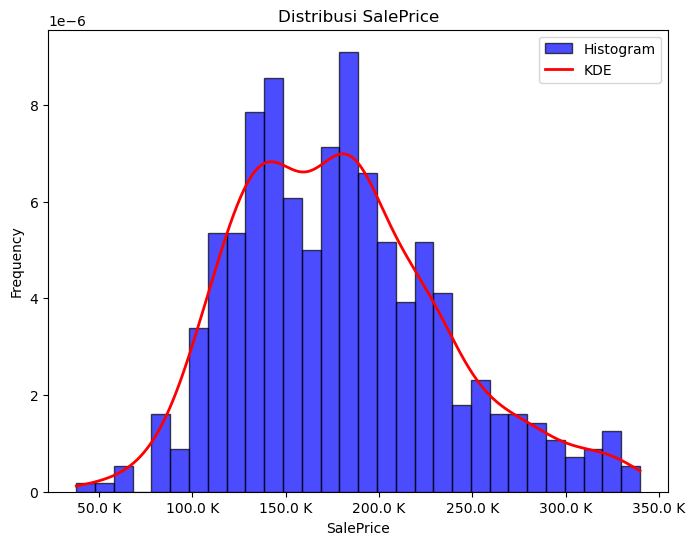

In [53]:
# Histogram Distribusi
plt.figure(figsize = (8, 6))
plt.hist(y_train, bins = 30, color = 'blue', alpha = 0.7, edgecolor = 'black', density = True, label = 'Histogram')

# Menambahkan KDE (Kernel Density Estimation)
kde = gaussian_kde(y_train)
x_vals = np.linspace(y_train.min(), y_train.max(), 1000)
kde_vals = kde(x_vals)
plt.plot(x_vals, kde_vals, color = 'red', linewidth = 2, label = 'KDE')

#
plt.title('Distribusi SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')

# Mengatur formatter untuk sumbu x dan y
formatter = ticker.FuncFormatter(lab_round)
plt.gca().xaxis.set_major_formatter(formatter)

plt.legend()

# 4. Menampilkan Plot
plt.show()

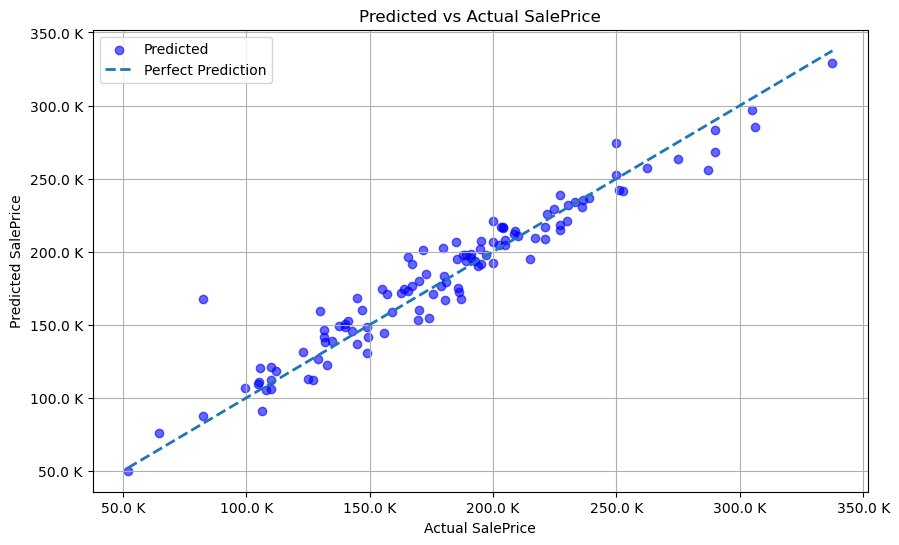

In [54]:
# Membuat scatter plot
plt.figure(figsize = (10, 6))
plt.scatter(y_valid, y_valid_pred, alpha = 0.6, color = 'blue', label = 'Predicted')
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], ls = '--', lw = 2, label = 'Perfect Prediction')

plt.title('Predicted vs Actual SalePrice')
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')

# Mengatur formatter untuk sumbu x dan y
formatter = ticker.FuncFormatter(lab_round)
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_major_formatter(formatter)

plt.legend()
plt.grid()

plt.show()